In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import traceback
import warnings
import functools
from dask_image.imread import imread
import imagecodecs
from PIL import Image
import dask.array as da
import scipy.spatial as spatial
import stlearn as st
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import corescpy as cr
from corescpy.ax import create_spot_grid

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

SPATIAL_KEY = "spatial"

col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution
l_r = {"CSF1": "CSF1R", "CSF2": ["CSF2RA", "CSF2RB"]}
plot_lr = ["CSF1_CSF1R", "CSF2_CSF2RA", "CSF2_CSF2RB"]

n_spots = 400
organism = "human"
resource = "connectomeDB2020_lit"
# distance = 200
distance = "auto"
min_med_neighbors = 5
min_spots = 2
n_pairs = 10000  # CHANGE DEFAULT TO 10000
n_top = 50
n_jobs = 20
layer = "counts"
cell_prop_cutoff = 0.1
n_perms = 10000
adj_method = "fdr_bh"
pval_adj_cutoff = 0.05
adj_axis = "spot"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

## Metadata

In [4]:
col_subject, col_condition = "Patient", "Condition"
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
key_uninfl, key_infl, key_stric = "Uninflamed", "Inflamed", "Stricture"
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
file_mdf = os.path.join(ddl, "samples.csv")  # metadata
m_d = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
m_d.loc[:, col_condition] = m_d.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
m_d.loc[:, col_sample_id] = m_d[[col_condition, col_sample_id_o]].apply(
    "-".join, axis=1)
m_d = m_d.set_index(col_sample_id)
print(m_d[[col_subject, col_condition]].reset_index(0)[
    col_condition].value_counts())
samps_paired = m_d.groupby("Patient").apply(
    lambda x: list(x.reset_index()[col_sample_id].sort_values()) if all((
        i in list(x.reset_index()[col_condition]) for i in [
            key_uninfl, key_infl, key_stric])) else np.nan).dropna(
                ).explode()
# m_d.reset_index().set_index([col_subject, col_condition]).sort_index()
samps_paired

Condition
Stricture     16
Uninflamed     5
Inflamed       5
Name: count, dtype: int64


Patient
50006      Inflamed-50006A
50006     Stricture-50006C
50006    Uninflamed-50006B
50217      Inflamed-50217A
50217     Stricture-50217C
50217    Uninflamed-50217B
50336      Inflamed-50336B
50336     Stricture-50336A
50336    Uninflamed-50336C
50403      Inflamed-50403A
50403    Stricture-50403C1
50403    Stricture-50403C2
50403    Uninflamed-50403B
50452      Inflamed-50452B
50452     Stricture-50452C
50452    Uninflamed-50452A
dtype: object

## Spatial Data

In [5]:
# File Paths & Options
libids = ["50452A", "50452B", "50006A", "50006B",
          "50217A", "50217B", "50336B", "50336C"]  # paired (un)inflamed
libids = [m_d.reset_index().set_index(
    col_sample_id_o).loc[i][col_sample_id] for i in libids]
dir_data = os.path.join(ddm, "bbdata2/outputs/TUQ97N")
out_dir = os.path.join(ddl, "outputs/TUQ97N/nebraska")
col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution

# Spatial Data
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])
file_path = functools.reduce(
    lambda x, y: list(x) + list(y), [np.array(files)[
        np.where(["-".join(i.split("-")[1:]) == os.path.basename(x).split(
            "__")[2].split("-")[0] for x in files])[0][0]] for i in libids])
adatas = dict(zip(libids, [sc.read(os.path.join(
    out_dir, f"{i}.h5ad")) for i in libids]))
for x in adatas:
    adatas[x].X = adatas[x].layers[layer].copy()

## Object Compatibility

We have to re-configure a few object attributes to make it compatible with the expectations of `stlearn`, including legacy Squidpy styles of storing morphology image(s) and `stlearn`'s bespoke columns for coordinates.

In [6]:
# Make Compatible with Expected Hard-Coded Columns/Attributes in stlearn Code
# max_coor = np.max(adata.obsm["spatial"])
# scale = 2000 / max_coor
for x in adatas:
    adatas[x].uns[SPATIAL_KEY] = {x: {"images": {}}}
scale = 1
quality = "hires"
spot_diameter_fullres = 15
for x in adatas:
    adatas[x].obs.loc[:, "imagecol"] = adatas[x].obsm["spatial"][:, 0] * scale
    adatas[x].obs.loc[:, "imagerow"] = adatas[x].obsm["spatial"][:, 1] * scale
    if "scalefactors" not in adatas[x].uns["spatial"]:
        adatas[x].uns["spatial"][x]["scalefactors"] = {}
        adatas[x].uns["spatial"][x]["scalefactors"][
            "tissue_" + quality + "_scalef"] = scale
        adatas[x].uns["spatial"][x]["scalefactors"][
            "spot_diameter_fullres"] = spot_diameter_fullres
        adatas[x].uns["spatial"][x]["use_quality"] = "hires"

# Full Resolution? (Not Compatible Yet with stlearn)
# image_kws = {}
# img_files = {f for f in os.listdir(img_dir) if f.endswith("_focus.ome.tif")}
# channel_names = {0: "DAPI"} if len(img_files) == 1 else {
#     0: "DAPI", 1: "ATP1A1/CD45/E-Cadherin", 2: "18S",
#     3: "AlphaSMA/Vimentin", 4: "dummy"}
# image_kws["c_coords"] = list(channel_names.values())
# image_path = os.path.join(img_dir, "morphology_focus_{:04}.ome.tif".format(
#     0) if len(img_files) > 1 else "morphology_focus.ome.tif")
# img = imread(image_path)
# if "c_coords" in image_kws and "dummy" in image_kws["c_coords"]:
#     img = da.concatenate([img, da.zeros_like(img[0:1])], axis=0)
# adata.uns["spatial"][library_id]["images"] = {"hires": sq.im.ImageContainer(
#     img, library_id=library_id)}

# Stlearn Way of Loading Images (Full Resolution)
# st.add.image(adata, library_id=library_id, quality=quality,
#              imgpath=image_path, scale=scale)

# Stlearn Way of Loading Images (Not Full Resolution)
for x in adatas:
    max_size = np.max([adatas[x].obs["imagecol"].max(),
                       adatas[x].obs["imagerow"].max()])
    max_size = int(max_size + 0.1 * max_size)
    img = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    adatas[x].uns["spatial"][x]["images"] = {"hires": np.array(img)}

# Create Grids 

`stlearn` can create Visum-like data from Xenium data by aggregating the singl cells into larger "spots" (reducing the resolution) and performing label transfer to annotate the cells according to the dominant cluster/cell type in that spot.

In [7]:
%%time

# Re-Load Instead of Running
# for x in adatas:
#     grids[x] = sc.read(os.path.join(out_dir, f"{x}_stlearn{suffix}.h5ad"))
#     _ = grids[x].uns.pop(col_cell_type + "_colors", None)
#     # _ = adatas[x].uns.pop(col_cell_type + "_colors", None)

# Run Gridding
grids = {}
for x in adatas:
    grids[x], _ = create_spot_grid(adatas[x], col_cell_type, n_spots,
                                   cmap="jana_40", n_jobs=n_jobs, title=x)



400 by 400 has 160000 spots


Normalization step is finished in adata.X
Gridding...


finding looplift candidates


ValueError: Failed in object mode pipeline (step: remove phis nodes)
Cannot add edge as dest node 2054 not in nodes {130, 9, 10, 266, 12, 396, 398, 142, 400, 401, 44, 46, 176, 306, 188, 200, 342, 346, 358, 234}

# Plot Cell Types

In [ ]:
# for x in grids[x]:
#     groups = list(grids[x].obs[col_cell_type].cat.categories)
#     for g in groups:
#         fig, axes = plt.subplots(ncols=3, figsize=(20, 8))
#         group_props = grids[x].uns[col_cell_type][g].values
#         grids[x].obs.loc[:, "Group"] = group_props
#         st.pl.feat_plot(grids[x], feature="Group", ax=axes[0],
#                         show_plot=False, vmax=1, show_color_bar=False)
#         st.pl.cluster_plot(grids[x], use_label=col_cell_type,
#                            list_clusters=[g], ax=axes[1], show_plot=False)
#         st.pl.cluster_plot(grids[x], use_label=col_cell_type,
#                            list_clusters=[g], ax=axes[2], show_plot=False)
#         axes[0].set_title(f"Grid {g} Proportions (Maximum = 1)")
#         axes[1].set_title(f"Grid {g} Maximum Spots")
#         axes[2].set_title(f"Individual Cell {g}")
#         fig.suptitle(x)
#         plt.show()

## Check Number of Neighbors Given Different Distance Parameters

Per https://github.com/BiomedicalMachineLearning/stLearn/issues/186#issuecomment-1238036775

If distance is set to "auto" in the options cell earlier, then this dataframe will be used to set object/sample-specific distance parameters according to the `min_med_neighbors` parameter (i.e., will use the minimum distance that yields at least that specified number).

Sample
Distances


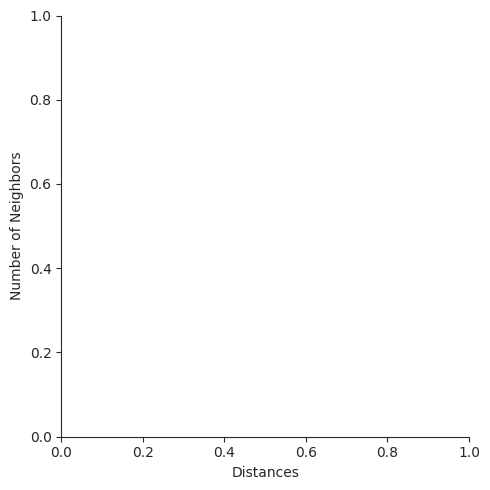

In [8]:
neighbors = {}
for d in np.arange(0, 301, 10):
    nnb = {}
    for x in grids:
        point_tree = spatial.cKDTree(grids[x].obs[["imagerow", "imagecol"]])
        nnb[x] = point_tree.query_ball_point(point_tree.data[0], d)
    neighbors[d] = pd.Series([len(nnb[i]) for i in nnb], index=pd.Index(
        grids.keys(), name=col_sample_id))
neighbors = pd.concat(neighbors, names=["Distances"]).unstack(col_sample_id)
sb.relplot(neighbors.stack().to_frame("Number of Neighbors"), kind="line",
           hue=col_sample_id, x="Distances", y="Number of Neighbors")
neighbors

# Analysis

**Important Input**

`adj_axis`: Per `stlearn` documentation: "adjusting by no. of LRs tested per spot (LR), no. of spots tested per LR (spot), or no adjustment (None)".

`distance`: Per author on `stlearn` GitHub: Distance is the "pixel length as the radius from each spot center. We will query all the spots within that radius." Also see https://github.com/BiomedicalMachineLearning/stLearn/issues/199#issuecomment-1272672934.

**Important Output**

`grid.uns["lr_summary"]`: Summarizes results for each ligand-receptor pair (number of spots with L-R, number of significant spots, and p-values).

`grid.obsm["lr_scores"]`: Ligand-receptor pair scores.

`grid.obsm["lr_sig_scores"]`: Rows = spots and columns = ligand-receptor pairs. Per stLearn GitHub issue, "Positive values in this matrix indicate significance of the LR in the respective spot (non-significant spots are set to zero)." It has the same index as in `grid.uns["lr_summary"]`.

In [ ]:
%%time

distances = {}
for x in grids:
    ddd = min(neighbors[x].index.values[np.where(np.array(neighbors[x].apply(
        lambda y: y >= min_med_neighbors)))[0]]
              )  # least distance to have >= specified # of median neighbors
    distances[x] = ddd if distance == "auto" else distance  # auto or fixed?
    kws = dict(n_spots=n_spots, organism=organism, resource=resource,
               distance=distances[x], min_med_neighbors=min_med_neighbors,
               min_spots=min_spots, n_pairs=n_pairs, n_top=n_top,
               n_jobs=n_jobs, layer=layer, cell_prop_cutoff=cell_prop_cutoff,
               n_perms=n_perms, adj_method=adj_method,
               pval_adj_cutoff=pval_adj_cutoff, adj_axis=adj_axis)
    for v in kws:
        grids[x].obs.loc[:, v] = str(kws[v])  # store keyword argument in .obs
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
    grids[x] = analyze_lr_spatial(
        grids[x], col_cell_type, distances[x], min_spots, n_pairs,
        n_perms=n_perms, n_jobs=n_jobs, cell_prop_cutoff=cell_prop_cutoff,
        resource=resource, organism=organism, adj_axis=adj_axis,
        pval_adj_cutoff=pval_adj_cutoff, adj_method=adj_method)
pd.concat([grids[x].uns["lr_summary"] for x in grids],
          keys=grids.keys(), names=[col_sample_id])

In [53]:
    ddd = min(neighbors[x].index.values[np.where(np.array(neighbors[x].apply(
        lambda y: y >= min_med_neighbors)))[0]]
              )  # least distance to have >= specified # of median neighbors
    distances[x] = ddd if distance == "auto" else distance  # auto or fixed?
    kws = dict(n_spots=n_spots, organism=organism, resource=resource,
               distance=distances[x], min_med_neighbors=min_med_neighbors,
               min_spots=min_spots, n_pairs=n_pairs, n_top=n_top,
               n_jobs=n_jobs, layer=layer, cell_prop_cutoff=cell_prop_cutoff,
               n_perms=n_perms, adj_method=adj_method,
               pval_adj_cutoff=pval_adj_cutoff, adj_axis=adj_axis)
    for v in kws:
        grids[x].obs.loc[:, v] = str(kws[v])  # store keyword argument in .obs
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
    grids[x] = analyze_lr_spatial(
        grids[x], col_cell_type, distances[x], min_spots, n_pairs,
        n_perms=n_perms, n_jobs=n_jobs, cell_prop_cutoff=cell_prop_cutoff,
        resource=resource, organism=organism, adj_axis=adj_axis,
        pval_adj_cutoff=pval_adj_cutoff, adj_method=adj_method)



Uninflamed-50452A


Calculating neighbours...


70 spots with no neighbours, 10 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 22 valid L-R pairs


Generating backgrounds & testing each LR pair...:   0%|           [ time left: ? ]

# Write Objects

In [16]:
suffix = ""
# suffix = f"_{date}"
for x in grids:
    grids[x].write_h5ad(os.path.join(out_dir, f"{x}_stlearn{suffix}.h5ad"))

# Plots

In [ ]:
# def plot_spatial_lr_qc(grid, col_cell_type, n_top=50):
#     """Plot QC & results from spatial LR & CCI analysis."""
#     figs = {}
#     try:
#         st.pl.lr_diagnostics(grid, figsize=(10, 2.5))  # QC
#         figs["qc_lr_diagnostics"] = plt.gcf()
#         st.pl.lr_n_spots(grid, n_top=n_top, figsize=(11, 3), max_text=100)
#         figs["qc_lr_spots"] = plt.gcf()
#         figs["qc_lr_spots"]].suptitle("L-R QC")
#     except Exception:
#         traceback.print_exc()
#         print(err, "\n\L-R QC plot failed")
#     try:
#         st.pl.cci_check(grid, col_cell_type, figsize=(16, 5))
#         figs["qc_cci"] = plt.gcf()
#         figs["qc_cci"].suptitle("CCI QC")
#     except Exception:
#         traceback.print_exc()
#         print(err, "\n\nCCI QC plot failed")
#     return figs


# def plot_spatial_lr_results(grid, col_cell_type, figsize=None,
#                             stats=None, plot_lr=3, n_top=50, **kwargs):
#     """Plot QC & results from spatial LR & CCI analysis."""
#     figs = {}
#     f_s = (12, 6) if figsize is None else figsize
#     if stats is None:
#         stats = ["lr_scores", "p_vals", "p_adjs", "-log10(p_adjs)"]
#     if plot_lr not in [False, None]:
#         plot_lr = [plot_lr] if isinstance(plot_lr, str) else grid.uns[
#             "lr_summary"].index.values[:int(plot_lr)] if isinstance(plot_lr, (
#                 int, float)) else list(plot_lr)  # use top N (plot_lr)
#         ncols = 3 if len(plot_lr) > 3 else len(plot_lr)  # L-R facets (row)
#         nrows = int(len(plot_lr) / ncols) if ncols > 1 else 1  # L-R columns
#     st.pl.lr_summary(grid, n_top=n_top, figsize=f_s)  # plot L-R ranks
#     figs["lr_ranks"] = plt.gcf()
#     if plot_lr is not False:
#         fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
#         if fig is None or axes is None:
#             fig, axes = plt.subplots(ncols=len(stats), nrows=len(plot_lr),
#                                         figsize=f_s)  # subplots: L-R pairs
#         for r, lr in enumerate(plot_lr):  # iterate ligand-receptors
#             kws = {"show_color_bar": False, **kwargs}
#             try:
#                 for c, stat in enumerate(stats):  # iterate statistics
#                     st.pl.lr_result_plot(
#                         grid, use_result=stat, use_lr=lr,
#                         fig=fig, ax=axes[r, c], **kws)  # plot L-R
#                     axes[r, c].set_title(f"{lr} {stat}")
#             except Exception:
#                 traceback.print_exc()
#                 print(f"Results summary plot error for {lr}")
#         figs["results"] = fig, axes
#     return figs



# def plot_spatial_lr_map(grid, col_cell_type, figsize=None,
#                         plot_lr=3, min_total=100, **kwargs):
#     """Plot QC & results from spatial LR & CCI analysis."""
#     figs = {}
#     f_s = (12, 6) if figsize is None else figsize
#     if plot_lr not in [False, None]:
#         plot_lr = [plot_lr] if isinstance(plot_lr, str) else grid.uns[
#             "lr_summary"].index.values[:int(plot_lr)] if isinstance(plot_lr, (
#                 int, float)) else list(plot_lr)  # use top N (plot_lr)
#         ncols = 3 if len(plot_lr) > 3 else len(plot_lr)  # L-R facets (row)
#         nrows = int(len(plot_lr) / ncols) if ncols > 1 else 1  # L-R columns
#     if "lr_colors" in kwargs:
#         kwargs["lr_colors"] = dict(zip(kwargs["lr_colors"], [
#             mpl.colors.to_hex(kwargs["lr_colors"][u])
#             for u in kwargs["lr_colors"]]))  # convert colors to hex
#     st.pl.cci_map(grid, col_cell_type, **kwargs)
#     figs["map"] = plt.gcf()
#     if plot_lr is not False:
#         fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
#         if fig is None or axes is None:  # subplots: L-R pairs
#             fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=f_s)
#         for i, lr in enumerate(plot_lr):  # iterate L-R pairs
#             try:
#                 st.pl.cci_map(grid, col_cell_type, lr, show=False,
#                               ax=axes.flatten()[i], **kwargs)  # heatmap plot
#             except Exception:
#                 traceback.print_exc()
#                 print(f"CCI map plot error for {lr}")
#         plt.show()
#         try:
#             st.pl.lr_cci_map(grid, col_cell_type, lrs=plot_lr,
#                              min_total=min_total, figsize=f_s)
#         except Exception:
#             traceback.print_exc()
#         figs["map_lr"] = fig
#     return figs


# def plot_spatial_lr_network(grid, col_cell_type, **kwargs):
#     """Plot QC & results from spatial LR & CCI analysis."""
#     kind_all = ["net", "chord"]
#     kind = [kind_all if kind.lower() == "all" else kind.lower()] if (
#         isinstance(kind, str)) else [k.lower() for k in kind]
#     if "net" in kind:
#         f_s = (12, 6) if figsize is None else figsize
#         pos_1 = st.pl.ccinet_plot(grid, col_cell_type, return_pos=True)  # all
#         if plot_lr is not False:
#             for lr in plot_lr:  # iterate L-R pairs
#                 try:
#                     st.pl.ccinet_plot(grid, col_cell_type, lr, figsize=f_s,
#                                       min_counts=min_counts,
#                                       pos=pos_1, **kwargs)
#                 except Exception as err:
#                     print(f"Net plot error for {lr}")
#     if "chord" in kind:
#         for lr in plot_lr:  # iterate L-R pairs
#             try:
#                 st.pl.lr_chord_plot(grid, col_cell_type, lr, **kwargs)
#             except Exception:
#                 traceback.print_exc()
#                 print(f"Chord plot error for {lr}")


# def plot_spatial_lr_arrow(grid, col_cell_type, kind="results", figsize=None,
#                           sig_spots=False, sig_cci=True, show_arrows=True,
#                           stats=None, plot_lr=3, n_top=50, min_total=100, **kwargs):
#     """Plot QC & results from spatial LR & CCI analysis."""
#     figs = {}
#     f_s = (12, 6) if figsize is None else figsize
#     if "lr_colors" in kwargs:
#         kwargs["lr_colors"] = dict(zip(kwargs["lr_colors"], [
#             mpl.colors.to_hex(kwargs["lr_colors"][u])
#             for u in kwargs["lr_colors"]]))  # convert colors to hex
#     if plot_lr is not False:
#         fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
#         if fig is None or axes is None:
#             fig, axes = plt.subplots(ncols=len(stats), nrows=len(plot_lr),
#                                      figsize=f_s)  # subplots: L-R pairs
#         for r, lr in enumerate(plot_lr):  # iterate ligand-receptors
#             kws = {"show_color_bar": False, **kwargs}
#             try:
#                 for c, stat in enumerate(stats):  # iterate statistics
#                     st.pl.lr_result_plot(grid, use_result=stat, ax=axes[r, c],
#                                          use_lr=lr, fig=fig, **kws)  # plot
#                     axes[r, c].set_title(f"{lr} {stat}")
#             except Exception:
#                 traceback.print_exc()
#                 print(f"Results summary plot error for {lr}")
#         figs["results"] = fig, axes

In [ ]:
def plot_spatial_lr(grid, col_cell_type, kind="results", figsize=None,
                    sig_spots=False, sig_cci=True, show_arrows=True,
                    stats=None, plot_lr=3, n_top=50, min_total=100, **kwargs):
    """Plot QC & results from spatial LR & CCI analysis."""
    figs = {}
    f_s = (12, 6) if figsize is None else figsize
    if stats is None:
        stats = ["lr_scores", "p_vals", "p_adjs", "-log10(p_adjs)"]
    kind_all = ["qc", "results", "arrow", "map", "net", "chord"]
    kind = [kind_all if kind.lower() == "all" else kind.lower()] if (
        isinstance(kind, str)) else [k.lower() for k in kind]
    if plot_lr not in [False, None]:
        plot_lr = [plot_lr] if isinstance(plot_lr, str) else grid.uns[
            "lr_summary"].index.values[:int(plot_lr)] if isinstance(plot_lr, (
                int, float)) else list(plot_lr)  # use top N (plot_lr)
        ncols = 3 if len(plot_lr) > 3 else len(plot_lr)  # L-R facets (row)
        nrows = int(len(plot_lr) / ncols) if ncols > 1 else 1  # L-R columns
    if "lr_colors" in kwargs:
        kwargs["lr_colors"] = dict(zip(kwargs["lr_colors"], [
            mpl.colors.to_hex(kwargs["lr_colors"][u])
            for u in kwargs["lr_colors"]]))  # convert colors to hex

    # QC/Diagnostics (Metrics Shouldn't Correlate Much with L-R Expression)
    if "qc" in kind:
        print(f"\n\n{'*' * 40}\nQC Plots\n{'*' * 40}\n\n"
              "Expression frequency and L-R/CCI metrics shouldn't correlate much"
              "; otherwise, increase `n_perms` and/or `n_pairs`.")
        try:
            st.pl.lr_diagnostics(grid, figsize=(10, 2.5))  # QC
            figs["qc_lr_diagnostics"] = plt.gcf()
            st.pl.lr_n_spots(grid, n_top=n_top, figsize=(11, 3), max_text=100)
            figs["qc_lr_spots"] = plt.gcf()
        except Exception:
            traceback.print_exc()
            print(err, "\n\L-R QC plot failed")
        try:
            st.pl.cci_check(grid, col_cell_type, figsize=(16, 5))
            figs["qc_cci"] = plt.gcf()
            figs["qc_cci"].suptitle("CCI Check: Interactions & cell type "
                                    "frequency shouldn't correlate much")
        except Exception:
            traceback.print_exc()
            print(err, "\n\nCCI QC plot failed")

    # Results Summary (Rankings of L-R Pairs by Number of Significant Spots)
    if "results" in kind:
        print(f"\n\n{'*' * 40}\nResults Plots\n{'*' * 40}\n\n")
        st.pl.lr_summary(grid, n_top=n_top, figsize=f_s)  # plot L-R ranks
        figs["lr_ranks"] = plt.gcf()
        if plot_lr is not False:
            fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
            if fig is None or axes is None:
                fig, axes = plt.subplots(ncols=len(stats), nrows=len(plot_lr),
                                         figsize=f_s)  # subplots: L-R pairs
            for r, lr in enumerate(plot_lr):  # iterate ligand-receptors
                kws = {"show_color_bar": False, **kwargs}
                try:
                    for c, stat in enumerate(stats):  # iterate statistics
                        st.pl.lr_result_plot(
                            grid, use_result=stat, use_lr=lr,
                            fig=fig, ax=axes[r, c], **kws)  # plot L-R
                        axes[r, c].set_title(f"{lr} {stat}")
                except Exception:
                    traceback.print_exc()
                    print(f"Results summary plot error for {lr}")
            figs["results"] = fig, axes

    # Color Spot by Mean L-R Expression in Spots Connected by Arrow
    if "arrow" in kind:
        fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
        if fig is None or axes is None:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                                     figsize=f_s, squeeze=False)
        for i, lr in enumerate(plot_lr):  # iterate L-R pairs
            axes.flatten()[i].set_title(lr)
            kws = dict(arrow_width=2, pt_scale=10, arrow_head_width=4,
                       arrow_cmap="YlOrRd", arrow_vmax=1.5, outer_mode=None,
                       outer_size_prop=1, fig=fig, ax=axes.flatten()[i],
                       sig_spots=sig_spots, sig_cci=sig_cci)
            kws.update({**kwargs, "show_arrows": False} if (
                col_cell_type is None) else {**kwargs})
            if "lr_colors" in kws:
                kws["lr_colors"] = {**kws["lr_colors"]}
                for v, k in enumerate(["l", "r", "lr"]):  # key palette by L-R
                    lab = lr.split("_")[v] if v < 2 else lr
                    kws["lr_colors"][lab] = kws["lr_colors"][k]
                    _ = kws["lr_colors"].pop(k)
            try:
                st.pl.lr_plot(grid, lr, use_label=col_cell_type, **kws)
            except Exception:
                traceback.print_exc()
                print(f"L-R arrow plot error for {lr}")
        figs["arrow"] = fig, axes
        plt.show()

    # Net Plot: # of Interactions between Cell Types across All L-R Pairs
    if "net" in kind:
        pos_1 = st.pl.ccinet_plot(grid, col_cell_type, return_pos=True)  # all
        if plot_lr is not False:
            for lr in plot_lr:  # iterate L-R pairs
                try:
                    st.pl.ccinet_plot(grid, col_cell_type, lr, min_counts=2,
                                      figsize=f_s, pos=pos_1, **kwargs)
                except Exception as err:
                    print(f"Net plot error for {lr}")

    # Chord Plot
    if "chord" in kind:
        # st.pl.lr_chord_plot(grid, col_cell_type)  # all
        if plot_lr is not False:
            for lr in plot_lr:  # just between selected pairs
                try:
                    st.pl.lr_chord_plot(grid, col_cell_type, lr)
                except Exception:
                    traceback.print_exc()
                    print(f"Chord plot error for {lr}")

    # Heatmap Equivalent of Net & Chord
    if "map" in kind:
        st.pl.cci_map(grid, col_cell_type, **kwargs)
        if plot_lr is not False:
            fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
            if fig is None or axes is None:
                fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                                         figsize=f_s)  # subplots: L-R pairs
            for i, lr in enumerate(plot_lr):  # iterate L-R pairs
                try:
                    figs["map"] = st.pl.cci_map(
                        grid, col_cell_type, lr, show=False,
                        ax=axes.flatten()[i], **kwargs)  # heatmap plot
                except Exception:
                    traceback.print_exc()
                    print(f"CCI map plot error for {lr}")
            plt.show()
            try:
                st.pl.lr_cci_map(grid, col_cell_type, lrs=plot_lr,
                                 min_total=min_total, figsize=(20, 4))
            except Exception:
                traceback.print_exc()
    return figs

## QC/Diagnostics

**First Set of Plots (For L-R Analysis; Scatter)**

`st.pl.lr_diagnostics`: Per `stlearn` documentation...

> A key aspect of the LR analysis is to control for LR expression level and frequency when calling significant hotspots.
>
> Hence, our diagnostic plots should show next to no correlation between the hotspots of the LR pairs and the expression level and frequency of expression.
>
> The following diagnostics allow us to check and make sure this is the case; if not, could indicate a larger number of permutations is required.
>
>
> * Left plot: Relationship between LR expression level (non-zero spots average median expression of genes in the LR pair) and the ranking of the LR.
> 
> * Right plot: Relationship between LR expression frequency (average proportion of zero spots for each gene in the LR pair) and the ranking of the LR.
> 
> [If] there is a...correlation between the LR expression frequency and number of significant spots, [this indicates] the n_pairs parameter should be set higher to create more accurate background distributions (10,000 pairs was used in the case of the paper version of the above).

**Second Set of Plots (For L-R Analysis; Bars)**

`st.pl.lr_n_spots`: Per `stlearn` documentation...
> The above boxplots show the number of spots with ligand-receptor scores for each LR on the y-axis, with the LR ranking on the x-axis. The bar area is stratified by spots which were significant (green) and non-significant (blue).
> 
> [If] there does appear to be some correlation with more highly frequent LR pairs and LR ranking...the n_pairs parameter above should be set higher.

**Third Set of Plots (for CCI Analysis)**

Interactions & cell type frequency shouldn't correlate much if well-controlled for.

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="qc")

## L-R Results Summary

Rankings, p-values, and scores

In [ ]:
sig_spots = True
# sig_spots = False
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="results",
                    plot_lr=plot_lr, sig_spots=sig_spots)

## L-R Co-Expression

`outer_mode` & corresponding color map arguments: Per `stlearn` documentation...
> The mode for the larger points when displaying LR expression; can either be ‘binary’ or ‘continuous’ or None. 
* > ‘Binary’ discretizes each spot as expressing L, R, both, or neither. 
   - `inner_cmap`: "Cmap for the inner point"
   - `lr_colors`: "Specifies the colors of the LRs...{‘l’: color, ‘r’: color, ‘lr’: color, ‘’: color}; the last key-value indicates colour for spots not expressing the ligand or receptor"
* > ‘Continuous’ shows color gradient for levels of LR expression by plotting two points for each spot, the ‘inner’ point is the receptor expression levels, and the ‘outer’ point is the ligand expression level. None plots no ligand/receptor expression.
   - `l_cmap`:  "Cmap for coloring the ligand expression"
   - `r_cmap`: "Cmap for coloring the receptor expression"
   - `lr_cmap`: "Cmap for coloring coexpression"

`min_expr`: Per `stlearn`..."The minimum expr above which LR considered expressed when plotting binary LR expression."

In [ ]:
# Set to None for Just L-R; `col_cell_type` to Show Labels Too
cct = None
# cct = col_cell_type

# Plot
for m in ["binary", "continuous"]:
    for s in [True, False]:
        for x in grids:
            palette = {"lr_colors": {"l": "g", "r": "b", "lr":
                "y", "": "w"}} if m == "binary" else {}
            title = str(f"{x}: {m.capitalize()} Coexpression"
                        f" ({'Significant Only' if s else 'All'})")
            plot_spatial_lr(grids[x], cct, kind="arrow", plot_lr=plot_lr,
                            outer_mode=m, title=title, sig_spots=s,
                            figsize=(35, 15), **palette)

## Cell-Cell Interactions

Per `stlearn`...
> The number of interactions refers to the number of times a spot with the reciever cell type expressed the ligand and the source cell type expressed the receptor in the same neighbourhood.

### CCI Map

**First Plot (CCI)**
Per `stlearn` documentation:
> This is a heatmap equivalent to the network diagrams and chordplots, it has more quantitative benefits.
> The # of interactions refers to the number of times a spot with the reciever cell type expressed the ligand and the source cell type expressed the receptor in the same neighbourhood.

**Second Plot (LR-CCI)**

CCI plots by individual L-R pairs

In [ ]:
# sig = False
sig = True  # only show significant
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="map",
                    figsize=(12 * len(plot_lr), 10), sig_interactions=sig,
                    title=str(f"{x}: Cell-Cell Interactions ("
                              f"(Significant{'' if sig else ' and N.S.'})"),
                    plot_lr=plot_lr)

### CCI Chord

Most useful for small numbers of cell types

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="chord", plot_lr=plot_lr)

### CCI Arrow

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="arrow",
                    figsize=(30, 30), plot_lr=plot_lr)

### CCI Net

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, title=f"{x}: L-R Interactions",
                    kind="net", plot_lr=plot_lr)

## Gene Expression

In [ ]:
if plot_lr is not None:
    genes = functools.reduce(lambda i, j: list(i) + list(j),
                             [i.split("_") for i in plot_lr])
    for g in genes:
        fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
        st.pl.gene_plot(grid, gene_symbols=g, ax=axes[0],
                        show_color_bar=False, show_plot=False)
        st.pl.gene_plot(adata, gene_symbols=g, ax=axes[1],
                        show_color_bar=False, show_plot=False, vmax=80)
        axes[0].set_title(f"Grid {g} Expression")
        axes[1].set_title(f"Cell {g} Expression")
        plt.show()

# Explore Summary

In [ ]:
lr_int_dfs = grid.uns[f"per_lr_cci_{col_cell_type}"]
lr_dfs = [lr_int_dfs[lr] if lr in lr_int_dfs else np.nan for lr in plot_lr]
[x.replace(0, np.nan).stack().dropna().to_frame(plot_lr[i]) if isinstance(
    x, pd.DataFrame) else None for i, x in enumerate(lr_dfs)]